
# Day 21 — Weekly Capstone: From Ridge to SHAP

## Topics Covered:

- What we’re doing & why it matters
- Part A — Regression
- Part B = Classification
- Use‑Case Narrative (Business lens)

## What we’re doing & why it matters

This capstone stitches together what we learned from **Ridge/Lasso/ElasticNet** through **model evaluation and interpretability (SHAP)**.  
We’ll do **two tracks**:

- **Part A — Regression:** Predict a continuous target with regularization, assess metrics (MSE, MAE, RMSE, R²), and interpret with permutation importance and partial dependence.
- **Part B — Classification:** Build a baseline classifier, evaluate with Accuracy/Precision/Recall/F1/ROC‑AUC, visualize the confusion matrix, and (optionally) interpret with SHAP if available.

We’ll use **sklearn’s Diabetes (regression)** and **Breast Cancer (classification)** datasets so you can reproduce results quickly.


In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Try SHAP (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    SHAP_AVAILABLE = False
    print("SHAP not available in this environment. We'll proceed with permutation importance and PDPs.")

# Repro
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


c:\Users\amey9\Documents\GitHub\DataScience-100-Days-of-Data-Science\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load data
diab = load_diabetes()
X_reg = pd.DataFrame(diab.data, columns=diab.feature_names)
y_reg = pd.Series(diab.target, name="target")

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

# Pipeline: Standardize -> Ridge
reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(random_state=RANDOM_STATE))
])

# Hyperparameter tuning for alpha
param_grid = {"model__alpha": np.logspace(-3, 3, 13)}
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_reg = GridSearchCV(reg_pipe, param_grid, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
grid_reg.fit(Xr_train, yr_train)

best_reg = grid_reg.best_estimator_
print("Best alpha:", grid_reg.best_params_["model__alpha"])

# Evaluate
yr_pred = best_reg.predict(Xr_test)
mse = mean_squared_error(yr_test, yr_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)

print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")


Best alpha: 1.0
MSE: 2892.015 | RMSE: 53.777 | MAE: 42.812 | R²: 0.454


  feature   importance
8      s5  2173.008668
4      s1  1808.299365
2     bmi  1178.029092
5      s2   700.261061
1     sex   388.457067
3      bp   263.638505
7      s4   158.854439
6      s3    87.454319
9      s6    18.339332
0     age   -17.503324


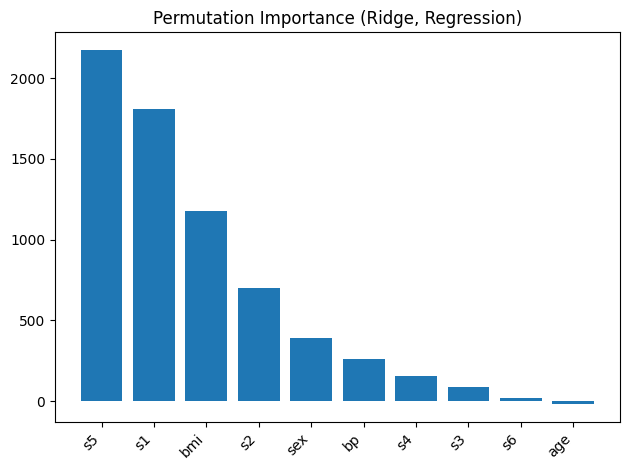

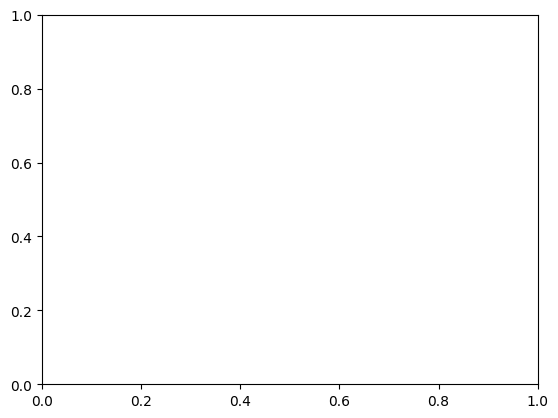

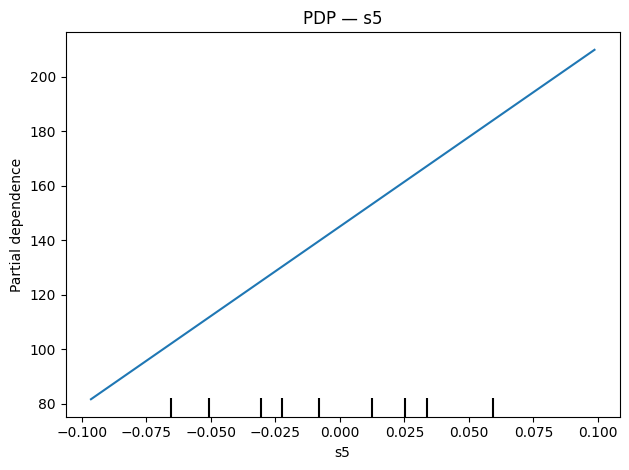

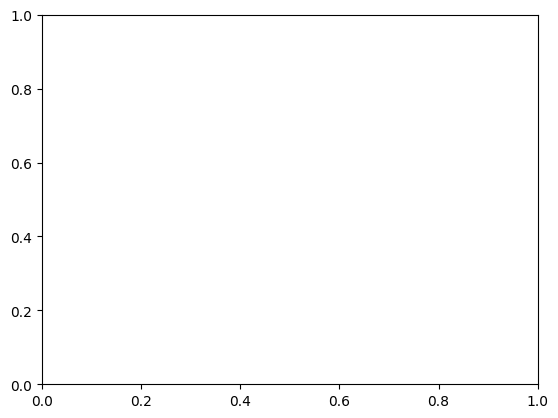

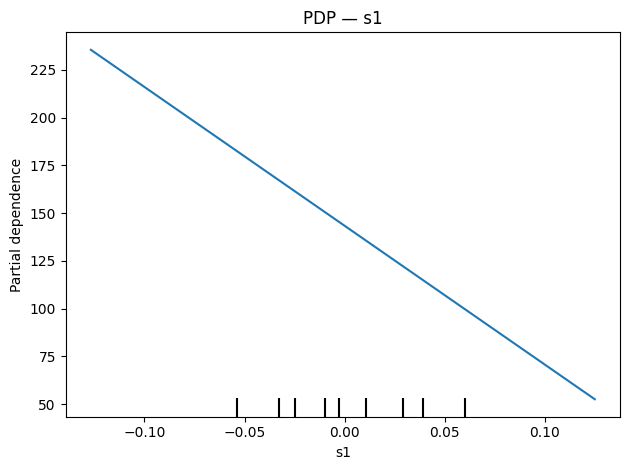

In [3]:

# Permutation importance on the test set
perm = permutation_importance(best_reg, Xr_test, yr_test, n_repeats=20, random_state=RANDOM_STATE, scoring="neg_mean_squared_error")
importances = pd.DataFrame({
    "feature": Xr_test.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

print(importances.head(10))

# Plot top 8
top_features = importances.head(8)["feature"].tolist()

plt.figure()
plt.bar(importances["feature"], importances["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Permutation Importance (Ridge, Regression)")
plt.tight_layout()
plt.show()

# Partial Dependence for the top 2 features
if len(top_features) >= 2:
    fig, ax = plt.subplots()
    PartialDependenceDisplay.from_estimator(best_reg, Xr_test, features=[top_features[0]])
    plt.title(f"PDP — {top_features[0]}")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    PartialDependenceDisplay.from_estimator(best_reg, Xr_test, features=[top_features[1]])
    plt.title(f"PDP — {top_features[1]}")
    plt.tight_layout()
    plt.show()
